## Plot climatological zonal-mean total column ozone

In this exercise you will read-in various total column ozone (TCO) datasets from a variety of sources:

1. Observations from Bodeker Scientific
2. Processed UKCA data submitted to phase 1 of the Chemistry-Climate Model Initative (CCMI1)
3. A ensemble of processed UKCA submitted to CCMI2022
4. UM-UKCA pp-file output run as part of the NERC ACSIS project

Some example plots will be given, along with suggested exercises for you to complete.

In [1]:
%%time
# need to import cfplot before cf due to issues with matplotlib and esmpy
import cfplot as cfp
import cf
import matplotlib.pyplot as plt
import numpy as np

CPU times: user 4.75 s, sys: 313 ms, total: 5.06 s
Wall time: 3.12 s


In [2]:
%%time
# define the locations of the various datasets
# CCMI2022 refD1 ensemble
ensdata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_Amon_UKESM1-StratTrop_refD1_r*i1p1f2_gn_19600101-20190101.nc'
# CCMI1 refC1
ccmidata='/home/ubuntu/Tutorials/UMvn13.0/data/toz_monthly_UMUKCA-UCAM_refC1_r1i1p1_*.nc'
# UKCA model data from ACSIS project, nudged to ERA5
ukcadata='/home/ubuntu/Tutorials/UMvn13.0/data/u-*/apm.pp/*.pp'
# Bodeker Scientific TCO dataset - https://www.bodekerscientific.com/data/total-column-ozone
# this has been preprocessed into a single file using ncks, ncatted, and ncrcat
# for i in `ls *.nc`; do echo $i; ncks -O --mk_rec_dmn time $i $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a created,global,d,, $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,longitude,o,c,degrees_east $i; done
# for i in `ls *.nc`; do echo $i; ncatted -O -a units,latitude,o,c,degrees_north $i; done
# ncrcat BSFilledTCO_V3.4.1_????_Monthly.nc ../BSFilledTCO_V3.4.1_Monthly.nc
obsdata='/home/ubuntu/Tutorials/UMvn13.0/data/Bodeker_3.4.1/*.nc'
# We would like to thank Bodeker Scientific, funded by the New Zealand Deep South National 
# Science Challenge, for providing the combined NIWA-BS total column ozone database.

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.29 μs


In [3]:
%%time
# read-in the UM-UKCA pp data, TCO is in STASH code s50i219
ukca=cf.read(ukcadata,select='stash_code=50219')[0]

CPU times: user 28 s, sys: 158 ms, total: 28.2 s
Wall time: 27.9 s


In [4]:
%%time
# persist the time to aid the collapse
ukca.coord('T').persist(inplace=True)
# want to look at the 1995-2005 range, and produce a monthly climatology
ukca_2000 = ukca.collapse('T: mean within years T: mean over years', within_years=cf.M(), over_years=cf.year(cf.wi(1995, 2005)))

CPU times: user 20min 9s, sys: 38.3 s, total: 20min 47s
Wall time: 20min 26s


In [5]:
%%time
ukca_zm=ukca_2000.collapse('X: mean')

CPU times: user 16.5 ms, sys: 117 μs, total: 16.6 ms
Wall time: 16.9 ms


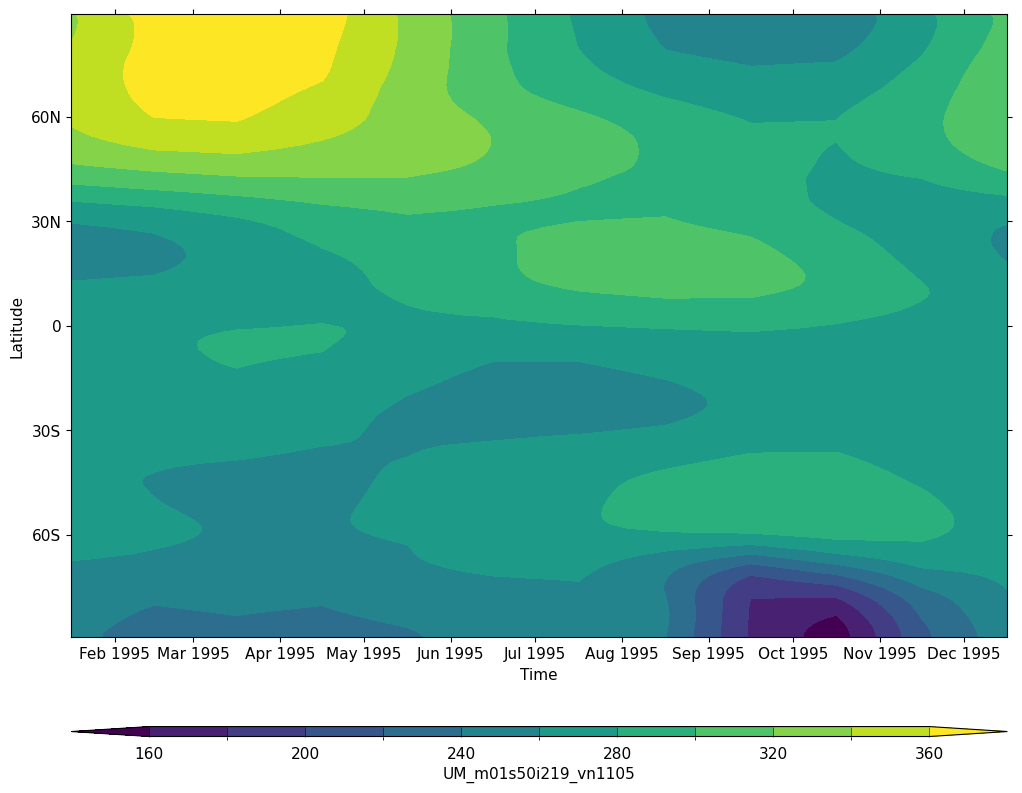

CPU times: user 4.52 s, sys: 267 ms, total: 4.78 s
Wall time: 4.51 s


In [6]:
%%time
cfp.con(ukca_zm, lines=False, swap_axes=True)

In [7]:
%%time
# Bodeker Total Column Ozone dataset - **preprocessed**
obs=cf.read(obsdata, select='equivalent_thickness_at_stp_of_atmosphere_ozone_content')[0]

CPU times: user 105 ms, sys: 47 μs, total: 105 ms
Wall time: 103 ms


In [8]:
%%time
if not obs.coord('T').has_bounds():
    # need to specify the cellsize here otherwise cannot collapse to produce a climatology with this dataset
    bounds = obs.coord('T').create_bounds(cellsize=cf.M(day=1))
    obs.coord('T').set_bounds(bounds)
# persist the time to aid the collapse
obs.coord('T').persist(inplace=True)
# want to look at the 1995-2005 range, and produce a monthly climatology
obs_2000 = obs.collapse('T: mean within years T: mean over years', within_years=cf.M(), over_years=cf.year(cf.wi(1995, 2005)), group_contiguous=0, group_span=False)

CPU times: user 2min 4s, sys: 2.95 s, total: 2min 7s
Wall time: 2min 6s


In [9]:
%%time
# for some reason can't over-plot these two datasets due to a property within the obs field
# regrid the UKCA to the Bodeker grid
ukca_2000_regrid=ukca_2000.regrids(obs_2000, 'linear')
# replace data for obs for plotting
obs_copy=ukca_2000_regrid.copy()
obs_copy.data=obs_2000.data
# now zonal mean
obs_copy_zm=obs_copy.collapse('X: mean')

CPU times: user 1.91 s, sys: 82 ms, total: 1.99 s
Wall time: 1.99 s


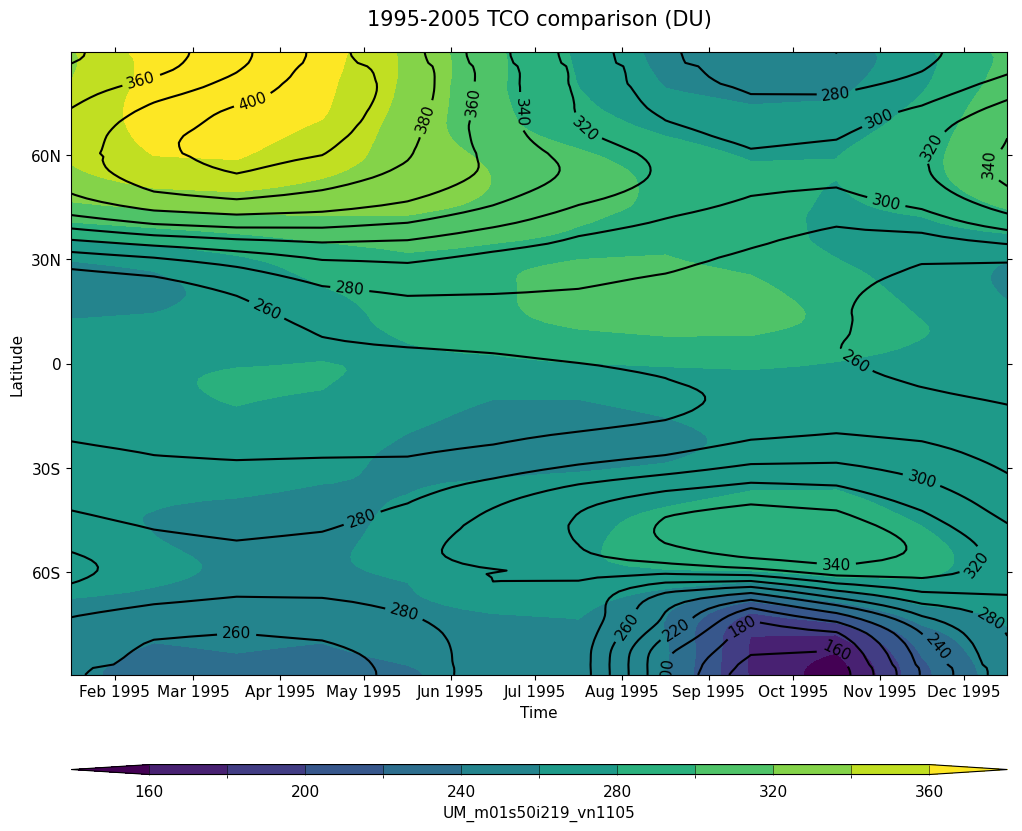

CPU times: user 14.3 s, sys: 922 ms, total: 15.2 s
Wall time: 14.5 s


In [10]:
%%time
# plot both
cfp.gopen()
cfp.con(ukca_zm, lines=False, fill=True, swap_axes=True)
# here data is from obs but grid information is from ukca
cfp.con(obs_copy_zm, x=ukca_zm.coordinate('time').data, fill=False, lines=True, swap_axes=True, title='1995-2005 TCO comparison (DU)')
cfp.gclose()

In [11]:
%%time
# 10-year files for CCMI1
ccmi=cf.read(ccmidata, select='equivalent_thickness_at_stp_of_atmosphere_ozone_content')[0]

CPU times: user 2.53 s, sys: 45.8 ms, total: 2.58 s
Wall time: 2.58 s


In [12]:
%%time
# persist the time to aid the collapse
ccmi.coord('T').persist(inplace=True)
# want to look at 1960-1969 and 2000-2009 ranges, and produce a monthly climatology
ccmi_1960s = ccmi.collapse('T: mean within years T: mean over years', within_years=cf.M(), over_years=cf.year(cf.wi(1960, 1969)))
ccmi_2000s = ccmi.collapse('T: mean within years T: mean over years', within_years=cf.M(), over_years=cf.year(cf.wi(2000, 2009)))

CPU times: user 6min 2s, sys: 8.55 s, total: 6min 11s
Wall time: 6min 7s


In [13]:
%%time
# produce a difference field
diff_abs=ccmi_2000s.copy()
diff_abs.data=ccmi_2000s.data - ccmi_1960s.data
diff_pc=ccmi_2000s.copy()
diff_pc.data=100.0*((ccmi_2000s.data - ccmi_1960s.data)/ccmi_1960s.data)
# change the units
diff_pc.set_property('units','%')

CPU times: user 25.2 ms, sys: 249 μs, total: 25.5 ms
Wall time: 26.4 ms


In [14]:
%%time
# zonal mean
abs_zm=diff_abs.collapse('X: mean')
pc_zm=diff_pc.collapse('X: mean')

CPU times: user 24.8 ms, sys: 0 ns, total: 24.8 ms
Wall time: 23.8 ms


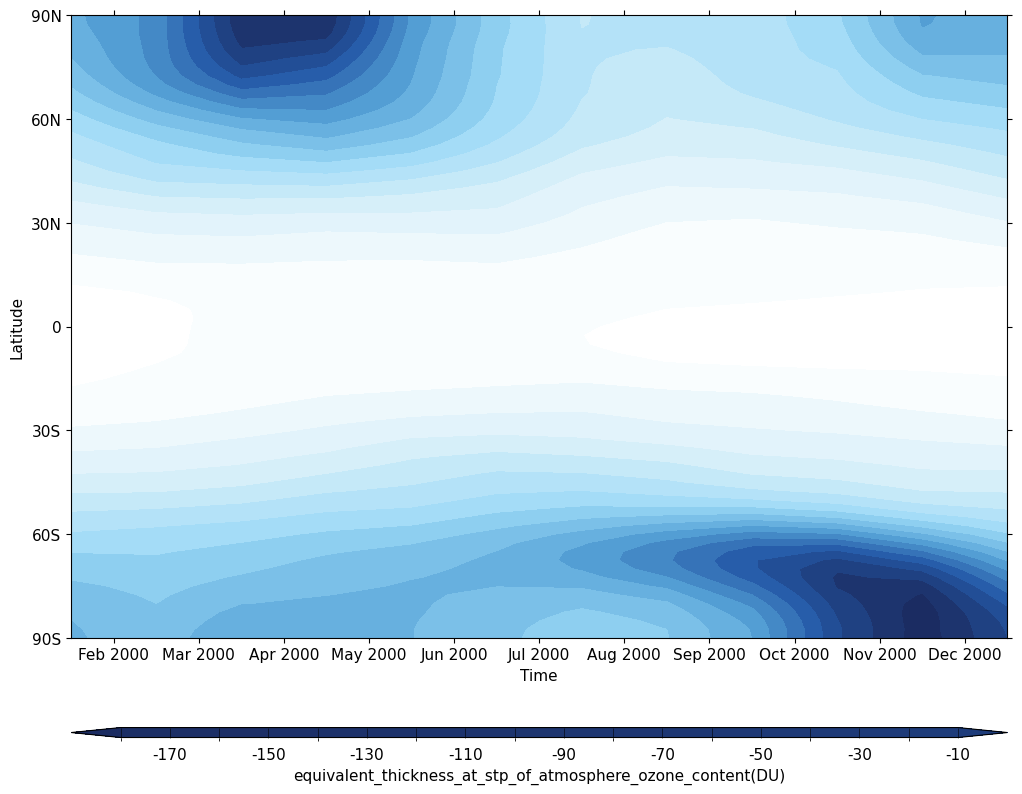

CPU times: user 17.2 s, sys: 756 ms, total: 17.9 s
Wall time: 17.4 s


In [15]:
%%time
cfp.cscale(scale='WhiteBlue', reverse=True)
cfp.con(abs_zm, lines=False, swap_axes=True)

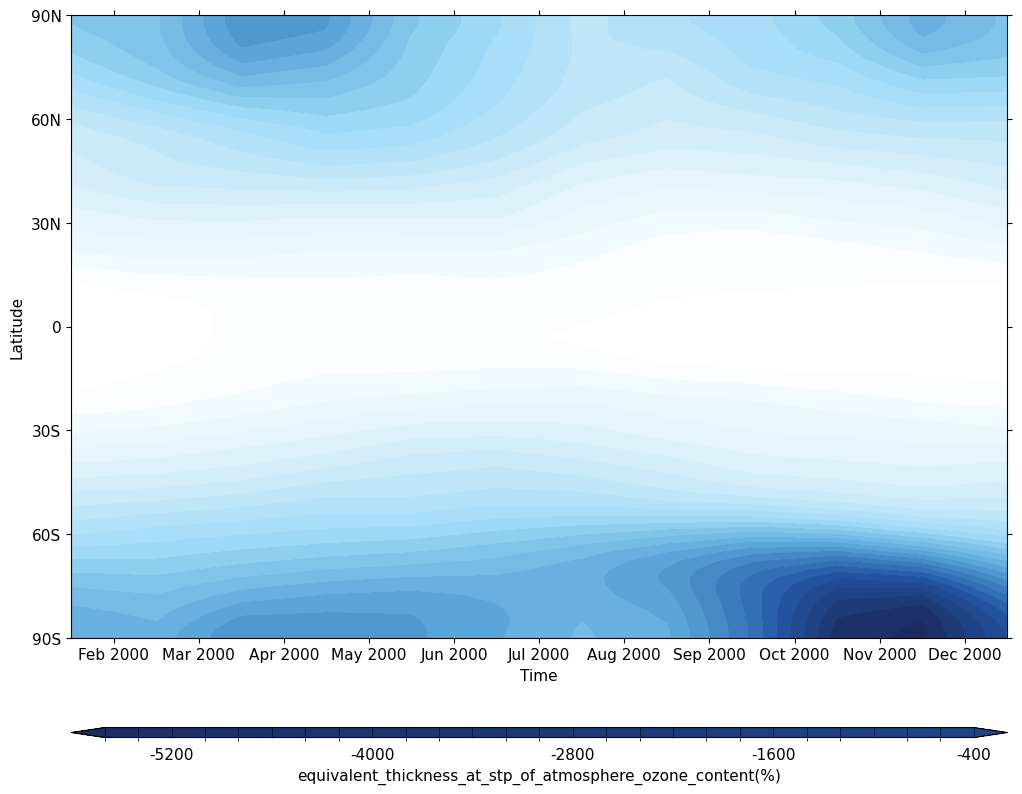

CPU times: user 17.4 s, sys: 875 ms, total: 18.2 s
Wall time: 17.6 s


In [16]:
%%time
cfp.cscale(scale='WhiteBlue', reverse=True)
cfp.con(pc_zm, lines=False, swap_axes=True)

### Further exercises to try:

1. Try comparing the CCMI2022 ensemble members against the ensemble mean.
2. Try comparing the nudged UM-UKCA ACSIS data against the CCMI2022 ensemble mean. Here the principal difference between the simulations is the use of nudging to constrain the winds and temperatures.